# Multiparametric MRI Oropharyngeal Cancer Primary Tumor Auto-Segmentation Deep Learning Analysis Notebook

Last updated: September 19, 2021

Author: Kareem A. Wahid

# Table of contents
1. [Introduction](#introduction)
2. [Dependencies](#dependencies)
    1. [Library Imports](#imports)
3. [Main Statistical Analysis](#main)
    1. [Loading Dictionary Data and Appending Clinical Information](#load)
    2. [Correlation Plots](#corr)
        1. [DataFrame Creation](#df1)
        1. [Plotting](#plot1)
    3. [Boxplots](#box) 
        1. [DataFrame Creation](#df2)
        2. [Plotting](#plot2)
        3. [Printing Mean and SD](#print)
        4. [Test for Normality](#norm)
    3. [Comparison Tests](#compare) 
        1. [DataFrame Creation](#df3)
        2. [Heatmap](#heat)
        2. [Subsite Comparison](#subsite)

# Introduction <a name="introduction"></a>

This is a notebook for the project titled "Development of a High-Performance MRI Oropharyngeal Cancer Primary Tumor Auto-Segmentation Deep Learning Model and Investigation of MultiParametric Channel Additive Effects: Results from a Prospective Imaging Registry" by the Fuller Lab at MD Anderson Cancer Center. It is primarily concerned with the statistical analysis of deep learning overlap metric results for prediction masks compared to ground truth masks. All patient data used in this notebook has been anonymized.

A pre-print of this work is avaliable at: https://www.medrxiv.org/content/10.1101/2021.07.27.21261114v1.



<div>
<img src="Network_v2.png">
</div>

This notebook asssumes the .ipynb file is nested inside a folder containing the neccessary folders/files with a directory structure as such:

In [ ]:
"""
Master_folder/
├── mpMRI_data_dict_analysis_github.ipynb <- this notebook
├── data_dict_new_anonymized.npy <- output of DL predictions, i.e. overlap metrics 
├── mpMRI_30_patient_demographics_anonymized.xlsx <- clinical data (all patient PHI removed)
"""

The names and nested structure of the folders must adhere to this convention exactly or the scripts below will not work since this notebook uses relative file paths. 

# Dependencies <a name="dependencies"></a>

## Library Imports <a name="imports"></a>

In [1]:
import os # system commands
import shutil
from operator import itemgetter

import numpy as np # calculations
import pandas as pd
pd.set_option('display.max_rows', None) # show all rows
from scipy import stats
from math import floor, ceil

import seaborn as sns # plotting
import matplotlib.pyplot as plt

import SimpleITK as sitk # imaging
from DicomRTTool.ReaderWriter import DicomReaderWriter # pip install DicomRTTool
import pydicom
from skimage import segmentation

%config InlineBackend.figure_format = 'retina' # for high quality figure print outs

The notebook should function properly as long as the following packages versions are installed: 
1. DicomRTTool version 0.3.13.
2. SimpleITK version 1.2.4.
3. Pydicom version 1.4.0.

If the notebook is run with different module versions, it is possible some functions may not work properly or give slightly different results from what was presented in the paper. 

In [2]:
!pip list # print list of installed packages for posterity, long output might spill over into next cell 

Package                            Version
---------------------------------- -------------------
-tatsmodels                        0.12.0
absl-py                            0.12.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autograd                           1.3
autograd-gamma                     0.5.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.

# Main statistical analysis <a name="main"></a>

## Loading dictionary data and appending clinical information <a name="load"></a>

First load the dictionary that was the output of the LOOCV deep learning autosegmentation pipeline. Note this dictionary file was the output of Admire combined with secondary script to genereate surface distance metrics using functions from https://github.com/deepmind/surface-distance. 

In [3]:
data = np.load("data_dict_new_anonymized.npy", allow_pickle=True).item() # Admire output + surface-distance functions 


distributed                        2.30.1
docopt                             0.6.2
docutils                           0.16
ecos                               2.0.7.post1
eli5                               0.11.0
emoji                              1.4.2
entrypoints                        0.3
et-xmlfile                         1.0.1
fastcache                          1.1.0
filelock                           3.0.12
flake8                             3.8.4
Flask                              1.1.2
Flask-Compress                     1.10.1
formulaic                          0.2.4
fsspec                             0.8.3
future                             0.18.2
gdown                              3.13.0
gevent                             20.9.0
glob2                              0.7
graphviz                           0.17
greenlet                           0.4.17
h5py                               2.10.0
HeapDict                           1.0.1
hiddenlayer                        0.3
html5lib

traitlets                          5.0.5
treeinterpreter                    0.2.3
trimesh                            3.9.20
typed-ast                          1.4.1
typing-extensions                  3.7.4.3
tzlocal                            2.1
ujson                              4.0.1
unicodecsv                         0.14.1
urllib3                            1.25.11
watchdog                           0.10.3
wcwidth                            0.2.5
webencodings                       0.5.1
Werkzeug                           1.0.1
wheel                              0.35.1
widgetsnbextension                 3.5.1
win-inet-pton                      1.1.0
win-unicode-console                0.5
wincertstore                       0.2
wrapt                              1.11.2
xarray                             0.17.0
xgboost                            1.4.2
xlrd                               1.2.0
XlsxWriter                         1.3.7
xlwings                            0.20.8
xlwt       

In [4]:
print(data) # display what the dictionary structure looks like 

{1: {'id': (27, 1, 9, 29, 30, 10, 11, 12, 13, 14, 15, 16, 2, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 3, 4, 5, 6, 28, 7, 8), 'Dice': [0.449, 0.719, 0.709, 0.809, 0.501, 0.68, 0.367, 0.766, 0.816, 0.82, 0.556, 0.685, 0.746, 0.477, 0.697, 0.846, 0.885, 0.81, 0.819, 0.574, 0.836, 0.549, 0.834, 0.839, 0.8, 0.586, 0.828, 0.875, 0.776, 0.836], 'MeanDistanceMesh(mm)': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], 'Hausdorff': [26.215, 6.062, 31.851, 6.225, 12.01, 13.537, 107.854, 25.11, 56.456, 3.64, 20.23, 14.379, 26.391, 12.903, 42.074, 5.0, 38.477, 18.125, 24.114, 46.554, 3.775, 92.69, 7.906, 51.174, 37.5, 20.797, 23.393, 5.408, 8.201, 12.042], 'HausdorffAvg': [2.07, 0.309, 0.653, 0.187, 1.043, 0.849, 16.948, 0.287, 1.03, 0.146, 0.946, 0.75, 0.55, 1.458, 3.589, 0.131, 0.371, 0.184, 0.251, 6.974, 0.132, 4.603, 0.192, 0.213, 0.249, 1.307, 0.441, 0.115, 0.633,

Now we take steps to append new information (tumor subsite) into the dictionary. This will be used later in the section "Subsite Comparison".

In [5]:
dictionary_MRNs = data[1]['id'] # get MRNs in list, note: all the MRNs are in this order
dictionary_MRNs = [int(MRN) for MRN in dictionary_MRNs] # make into integers

In [6]:
print(dictionary_MRNs) # display 

[27, 1, 9, 29, 30, 10, 11, 12, 13, 14, 15, 16, 2, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 3, 4, 5, 6, 28, 7, 8]


We will append data from a patient demographic excel sheet into the dictionary.

In [7]:
excel_df = pd.read_excel('mpMRI_30_patient_demographics_anonymized.xlsx', sheet_name=0) 
MRNs = excel_df['MRN'].tolist()
subsites = excel_df['Tumor subsite'].tolist()
subsites = [string.lower() for string in subsites]

In [8]:
print(subsites)

['base of tongue', 'tonsil', 'base of tongue', 'tonsil', 'base of tongue', 'tonsil', 'tonsil', 'base of tongue', 'base of tongue', 'base of tongue', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'base of tongue', 'base of tongue', 'base of tongue', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'base of tongue', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'tonsil']


In [9]:
MRN_subsite_joint = list(zip(MRNs, subsites)) # join into a list of tuples

In [10]:
d2 = {v: i for i, v in enumerate(dictionary_MRNs)}  # map elements to indexes, https://stackoverflow.com/questions/52834588/sort-list-of-tuples-based-on-another-list
sorted_MRN_subsite_joint = sorted(MRN_subsite_joint, key=lambda x: d2[x[0]])

In [11]:
print(sorted_MRN_subsite_joint) # this is a sorted list according to the original dictionary order 

[(27, 'tonsil'), (1, 'base of tongue'), (9, 'base of tongue'), (29, 'tonsil'), (30, 'tonsil'), (10, 'base of tongue'), (11, 'tonsil'), (12, 'tonsil'), (13, 'tonsil'), (14, 'tonsil'), (15, 'base of tongue'), (16, 'base of tongue'), (2, 'tonsil'), (17, 'base of tongue'), (18, 'tonsil'), (19, 'tonsil'), (20, 'tonsil'), (21, 'tonsil'), (22, 'tonsil'), (23, 'tonsil'), (24, 'tonsil'), (25, 'base of tongue'), (26, 'tonsil'), (3, 'base of tongue'), (4, 'tonsil'), (5, 'base of tongue'), (6, 'tonsil'), (28, 'tonsil'), (7, 'tonsil'), (8, 'base of tongue')]


In [12]:
sorted_subsite = list(zip(*sorted_MRN_subsite_joint))[1] # extract subsite

In [13]:
print(sorted_subsite) # this is what we want to append to dictionary 

('tonsil', 'base of tongue', 'base of tongue', 'tonsil', 'tonsil', 'base of tongue', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'base of tongue', 'base of tongue', 'tonsil', 'base of tongue', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'tonsil', 'base of tongue', 'tonsil', 'base of tongue', 'tonsil', 'base of tongue', 'tonsil', 'tonsil', 'tonsil', 'base of tongue')


In [14]:
for key, value in data.items(): # this adds a new dictionary item that corresponds to site for every LOOCV MRN 
    if key == 1 or key == 5: # key 1 = T2, key 5 = All channels
        value['Site'] = sorted_subsite
    elif key == 2 or key == 3 or key == 4: # channel combinatinos 
        for key2, value2 in value.items():
            value2['Site'] = sorted_subsite

## Correlation Plots <a name="corr"></a>
To assess any correlation of tumor size with model performance, we display line plots and calculate Pearson correlation coefficients with corresponding p-values of ground truth volume as a function of DSC, HD, and Surface DSC for every model.

### DataFrame Creation <a name="df1"></a>

Now we create a dataframe for channel combinations we are interested in so we can plot and analyze the data. We only care about the following combinations: T2 (baseline), T2+T1, T2+ADC, T2+Ktrans, T2+Ve, and All.

In [15]:
master_df = pd.DataFrame() 
df=pd.DataFrame.from_dict(data[1],orient='index').transpose() # for T2 base 
df['Channel']= "T2"
master_df = master_df.append(df)

In [16]:
# for 2 channel
for key, value in data[2].items():
    #print(key)
    #print(value.items())
    df=pd.DataFrame.from_dict(value,orient='index').transpose()
    df['Channel'] = "T2+"+ str(key)
    master_df = master_df.append(df)

In [17]:
df=pd.DataFrame.from_dict(data[5],orient='index').transpose() # for All 
df['Channel']= "All"
master_df = master_df.append(df)

In [18]:
master_df = master_df.reset_index(drop=True)

In [19]:
master_df # display 

,id,Dice,MeanDistanceMesh(mm),Hausdorff,HausdorffAvg,Jaccard,FalseNegativeDice,FalsePositiveDice,TruthVol(cc),TestVol(cc),...,Sensitivity,Specificity,PosPredictiveVal,F1Measure,HausdorffAvgBalanced,Surface Dice 3.0,95% Hausdorff,Average Surface Distance,Site,Channel
0,27,0.449,-1,26.215,2.07,0.29,0.964,0.138,16.151,6.705,...,0.318,1,0.766,0.449,2.244,0.471915,13.4536,5.75337,tonsil,T2
1,1,0.719,-1,6.062,0.309,0.561,0.295,0.268,7.25,7.055,...,0.709,1,0.729,0.719,0.357,0.959199,3.10483,1.01469,base of tongue,T2
2,9,0.709,-1,31.851,0.653,0.55,0.457,0.125,12.633,9.034,...,0.608,1,0.851,0.709,0.998,0.824464,83.5478,1.79522,base of tongue,T2
3,29,0.809,-1,6.225,0.187,0.679,0.21,0.173,4.702,4.532,...,0.794,1,0.824,0.809,0.218,0.982006,2.15407,0.768133,tonsil,T2
4,30,0.501,-1,12.01,1.043,0.334,0.404,0.594,1.738,2.104,...,0.554,1,0.457,0.501,1.285,0.816125,9,2.47416,tonsil,T2
5,10,0.68,-1,13.537,0.849,0.516,0.278,0.361,2.693,2.926,...,0.71,1,0.653,0.68,1.073,0.821472,13.0246,1.28959,base of tongue,T2
6,11,0.367,-1,107.854,16.948,0.225,0.42,0.845,45.192,69.58,...,0.467,0.99,0.303,0.367,27.422,0.201859,78.3454,4.39139,tonsil,T2
7,12,0.766,-1,25.11,0.287,0.621,0.325,0.143,3.76,3.135,...,0.702,1,0.842,0.766,0.349,0.926082,4.47214,1.22008,tonsil,T2
8,13,0.816,-1,56.456,1.03,0.69,0.217,0.15,37.684,35.225,...,0.79,0.999,0.845,0.816,1.282,0.839464,34.8,1.7709,tonsil,T2
9,14,0.82,-1,3.64,0.146,0.695,0.214,0.146,2.672,2.498,...,0.793,1,0.849,0.82,0.162,0.99909,1.8868,0.625376,tonsil,T2


In [20]:
master_df['TruthVol(cc)'] = master_df['TruthVol(cc)'].astype(float) # have to convert to floats to use in seaborn
master_df['Dice'] = master_df['Dice'].astype(float)
master_df['Hausdorff'] = master_df['Hausdorff'].astype(float)
master_df['Jaccard'] = master_df['Jaccard'].astype(float)
master_df['FalseNegativeDice'] = master_df['FalseNegativeDice'].astype(float)
master_df['FalsePositiveDice'] = master_df['FalsePositiveDice'].astype(float)
master_df['TotalVolumeOverlap'] = master_df['TotalVolumeOverlap'].astype(float)
master_df['Surface Dice 3.0'] = master_df['Surface Dice 3.0'].astype(float) 
master_df['95% Hausdorff'] = master_df['95% Hausdorff'].astype(float)
master_df['Average Surface Distance'] = master_df['Average Surface Distance'].astype(float)

master_df['Channel'] = master_df['Channel'].astype(str) # need this as string

In [21]:
# get range of truth vol
print(master_df['TruthVol(cc)'].min(), master_df['TruthVol(cc)'].max())

1.7380000352859497 45.19200134277344


### Plotting  <a name="plot1"></a>

In [22]:
def corr_plot(data, x, y, col, text_x, text_y):
    """
    Plots correlation graphs with r-squared for multiple variables. Adapted from https://stackoverflow.com/questions/25579227/seaborn-implot-with-equation-and-r2-text.
    Fairly inefficient and not very pythonic but gets the job done.
        Parameters:
            data (pd dataframe): DataFrame genereated from dictionary. 
            x (str): string corresponding to column of DataFrame you want on x axis. 
            y (str): string corresponding to column of DataFrame you want on y axis. 
            col (str): string corresponding to column of DataFrame you want each individual graph for. 
            text_x (float): x coordinate where you want r-squared text to show up. 
            text_y (float): y coordinate where you want r-squared text to show up. 
        Returns:
            None (generates in-line plots of display images).
    """
    
    def annotate(data, **kws): # this function is used in the map_dataframe function (function of functions)
        r, p = stats.pearsonr(data[x], data[y])
        ax = plt.gca()
        ax.text(text_x, text_y, 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)
    
    g = sns.lmplot(x=x, y=y, data=data, 
               col=col, col_wrap = 3, # made for 6 models so col wrap 3, height 3
               height=3, aspect=1)
    
    g.map_dataframe(annotate)
    
    for i, ax in enumerate(g.axes.flat): # have to do this to get labels after map_dataframe
        if i == 0:
            ax.set_ylabel(y)
        elif i == 3:
            ax.set_ylabel(y)
            ax.set_xlabel(x)
        elif i == 4 or i == 5:
            ax.set_xlabel(x)

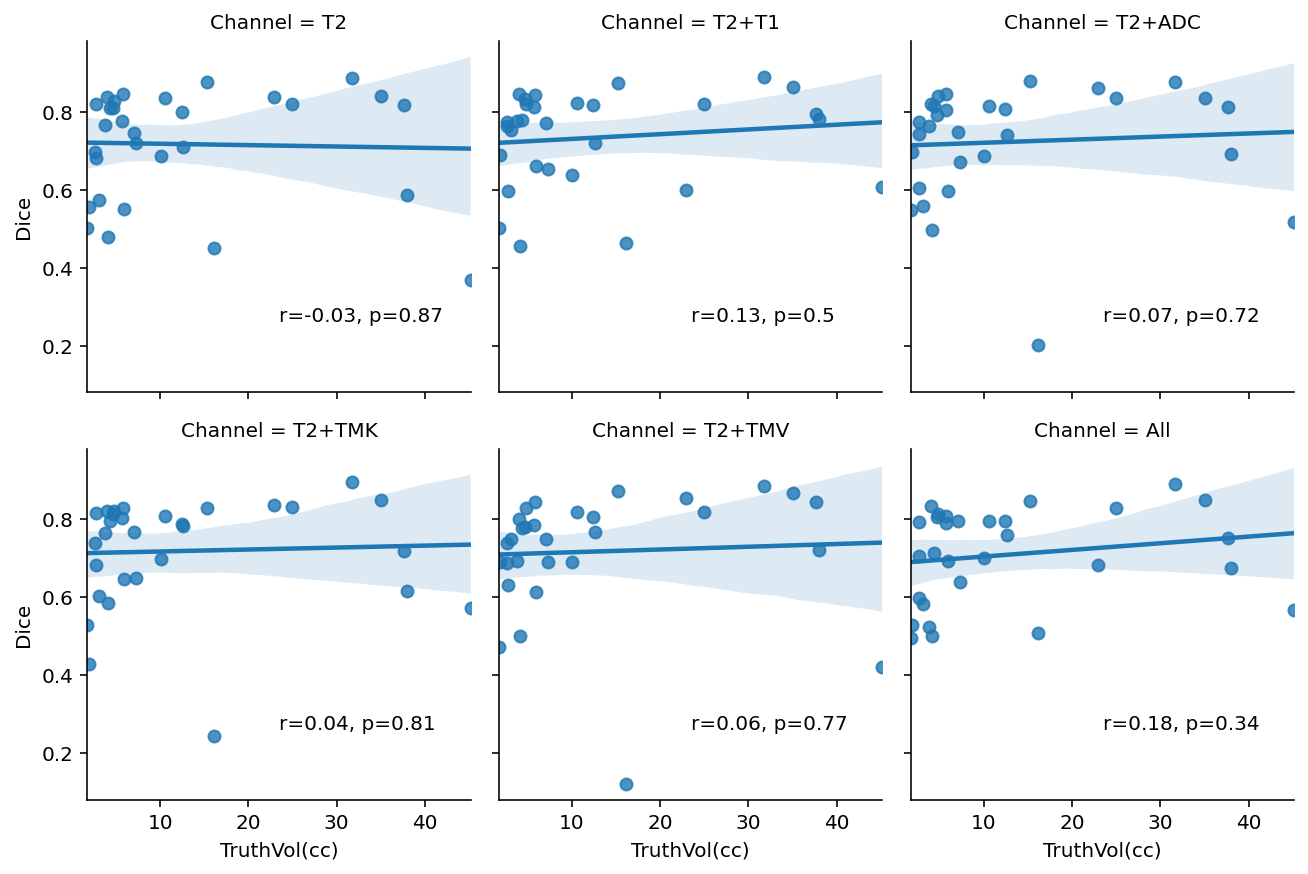

In [23]:
corr_plot(data = master_df, x = 'TruthVol(cc)', y = 'Dice', col = 'Channel', text_x = 0.5, text_y = 0.2)

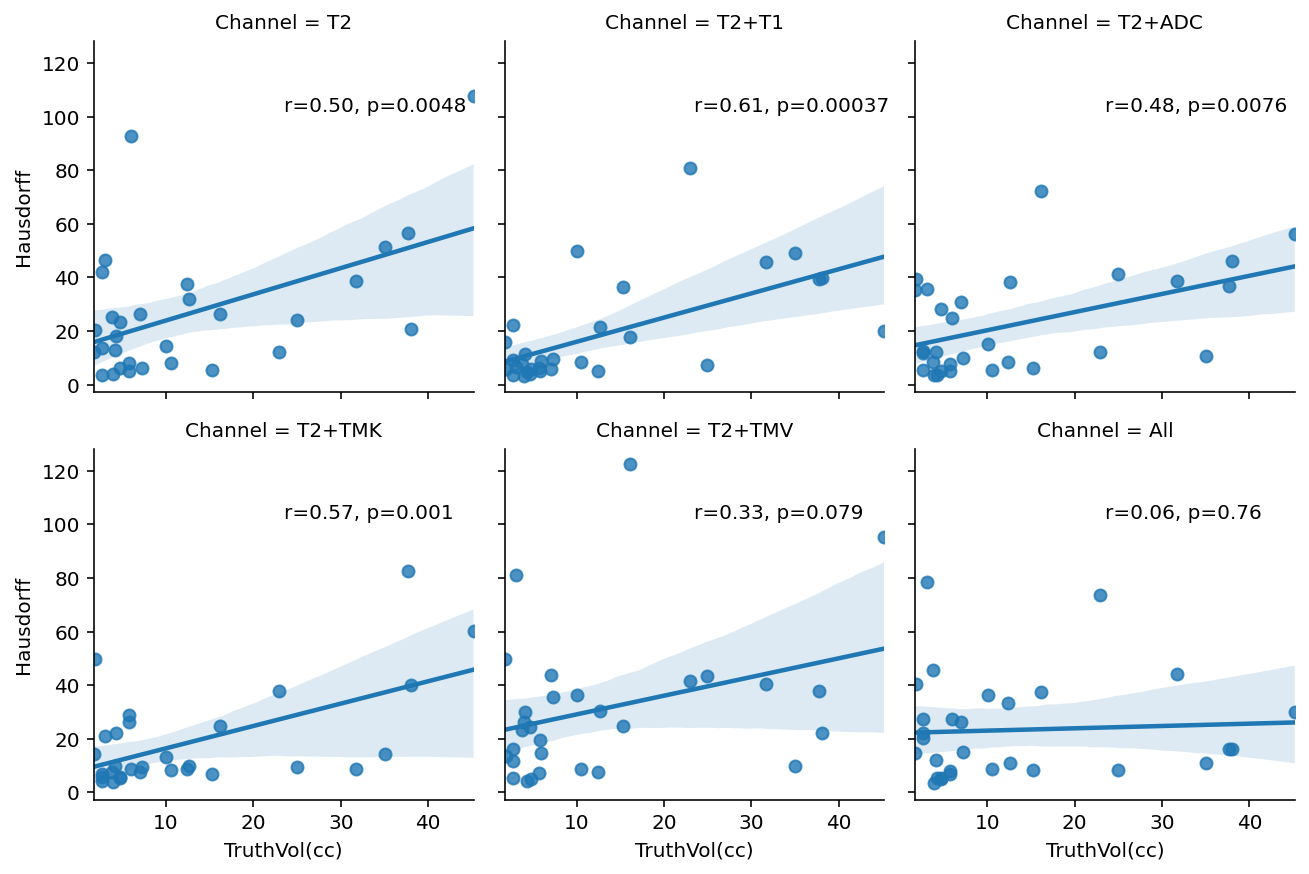

In [24]:
corr_plot(data = master_df, x = 'TruthVol(cc)', y = 'Hausdorff', col = 'Channel', text_x = 0.5, text_y = 0.8)

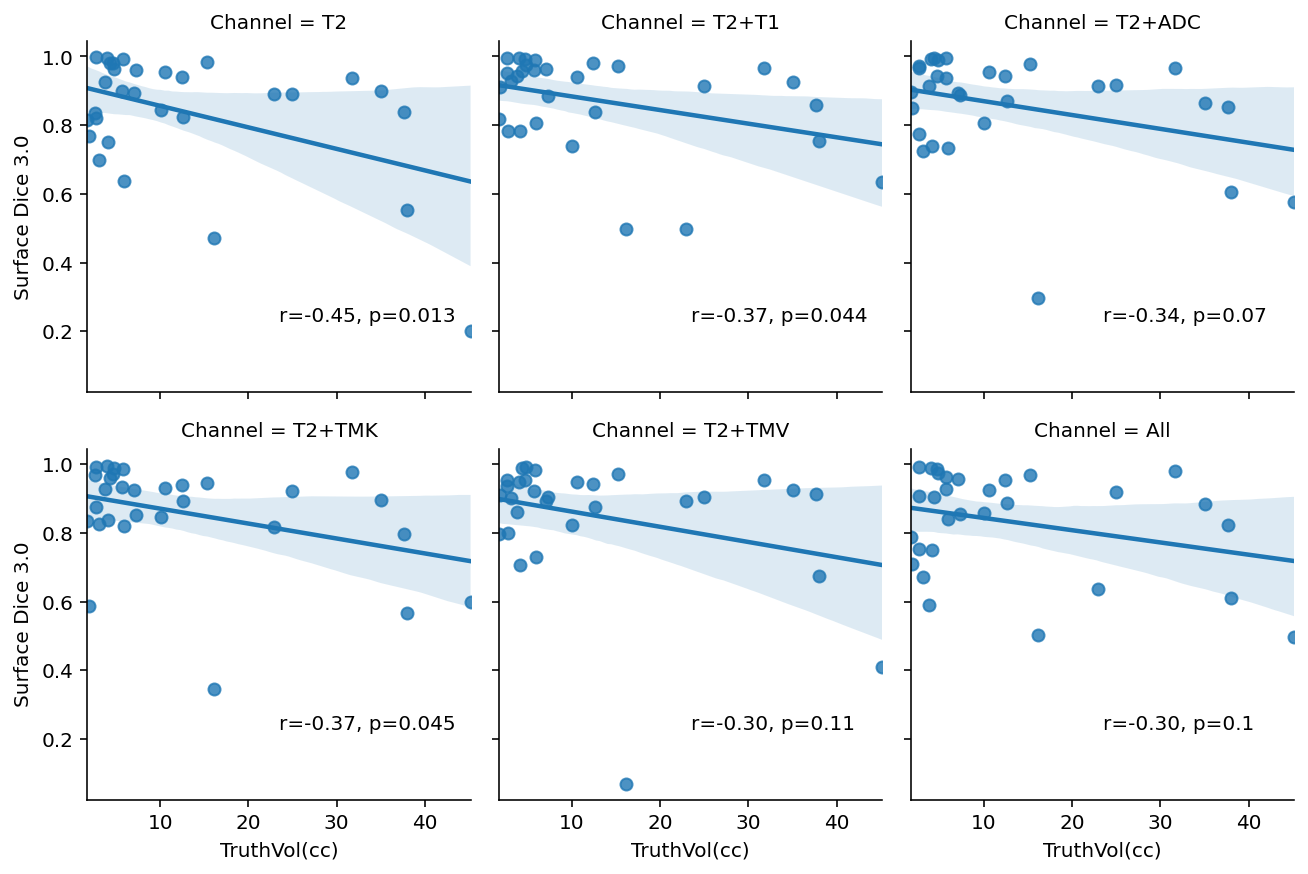

In [25]:
corr_plot(data = master_df, x = 'TruthVol(cc)', y = 'Surface Dice 3.0', col = 'Channel', text_x = 0.5, text_y = 0.2)

## Boxplots <a name="box"></a>
We graphed boxplots of model performance for the six models evaluated across different evaluation metrics.

### Dataframe Creation <a name="df2"></a>
Now create dataframe that you can iterate through to make series of boxplots for all metric model combinations of interest.

In [26]:
metric_list = [ 
    'Dice',
    'Hausdorff',
    'FalseNegativeDice',
    'FalsePositiveDice',
    'Sensitivity',
    'PosPredictiveVal',
    'Surface Dice 3.0',
    '95% Hausdorff',
    'Average Surface Distance',
]

In [27]:
master_df = pd.DataFrame() # generate dataframe
for key, value in data.items():
    if key == 1:
        model = "T2"
        #print(key)
        for key2, value2 in value.items():
            if key2 in metric_list:
                #print(key2) # key2 is metric in this case
                df=pd.DataFrame(value2, columns = ['Value'])
                df['Model'] = model
                df['Metric'] = key2
                df['Site'] = subsites 
                master_df = master_df.append(df)
    elif key == 5:
        model = "All"
        #print(key)
        for key2, value2 in value.items():
            if key2 in metric_list:
                #print(key2) # key2 is metric in this case
                df=pd.DataFrame(value2, columns = ['Value'])
                df['Model'] = model
                df['Metric'] = key2
                df['Site'] = subsites 
                master_df = master_df.append(df)
    elif key == 2:
        #print(key)
        for key2, value2 in value.items():
            #print(key2) # key2 is added modality in this case
            model = key2
            for key3, value3 in value2.items():
                if key3 in metric_list:
                    #print(key3)
                    df=pd.DataFrame(value3, columns = ['Value'])
                    df['Model'] = "T2+"+str(model)
                    df['Metric'] = key3
                    df['Site'] = subsites 
                    master_df = master_df.append(df)

In [28]:
master_df # display 

,Value,Model,Metric,Site
0,0.449000,T2,Dice,base of tongue
1,0.719000,T2,Dice,tonsil
2,0.709000,T2,Dice,base of tongue
3,0.809000,T2,Dice,tonsil
4,0.501000,T2,Dice,base of tongue
5,0.680000,T2,Dice,tonsil
6,0.367000,T2,Dice,tonsil
7,0.766000,T2,Dice,base of tongue
8,0.816000,T2,Dice,base of tongue
9,0.820000,T2,Dice,base of tongue


### Plotting <a name="plot2"></a>

C:\Users\kawahid\Anaconda3\lib\site-packages\seaborn\categorical.py:3793: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


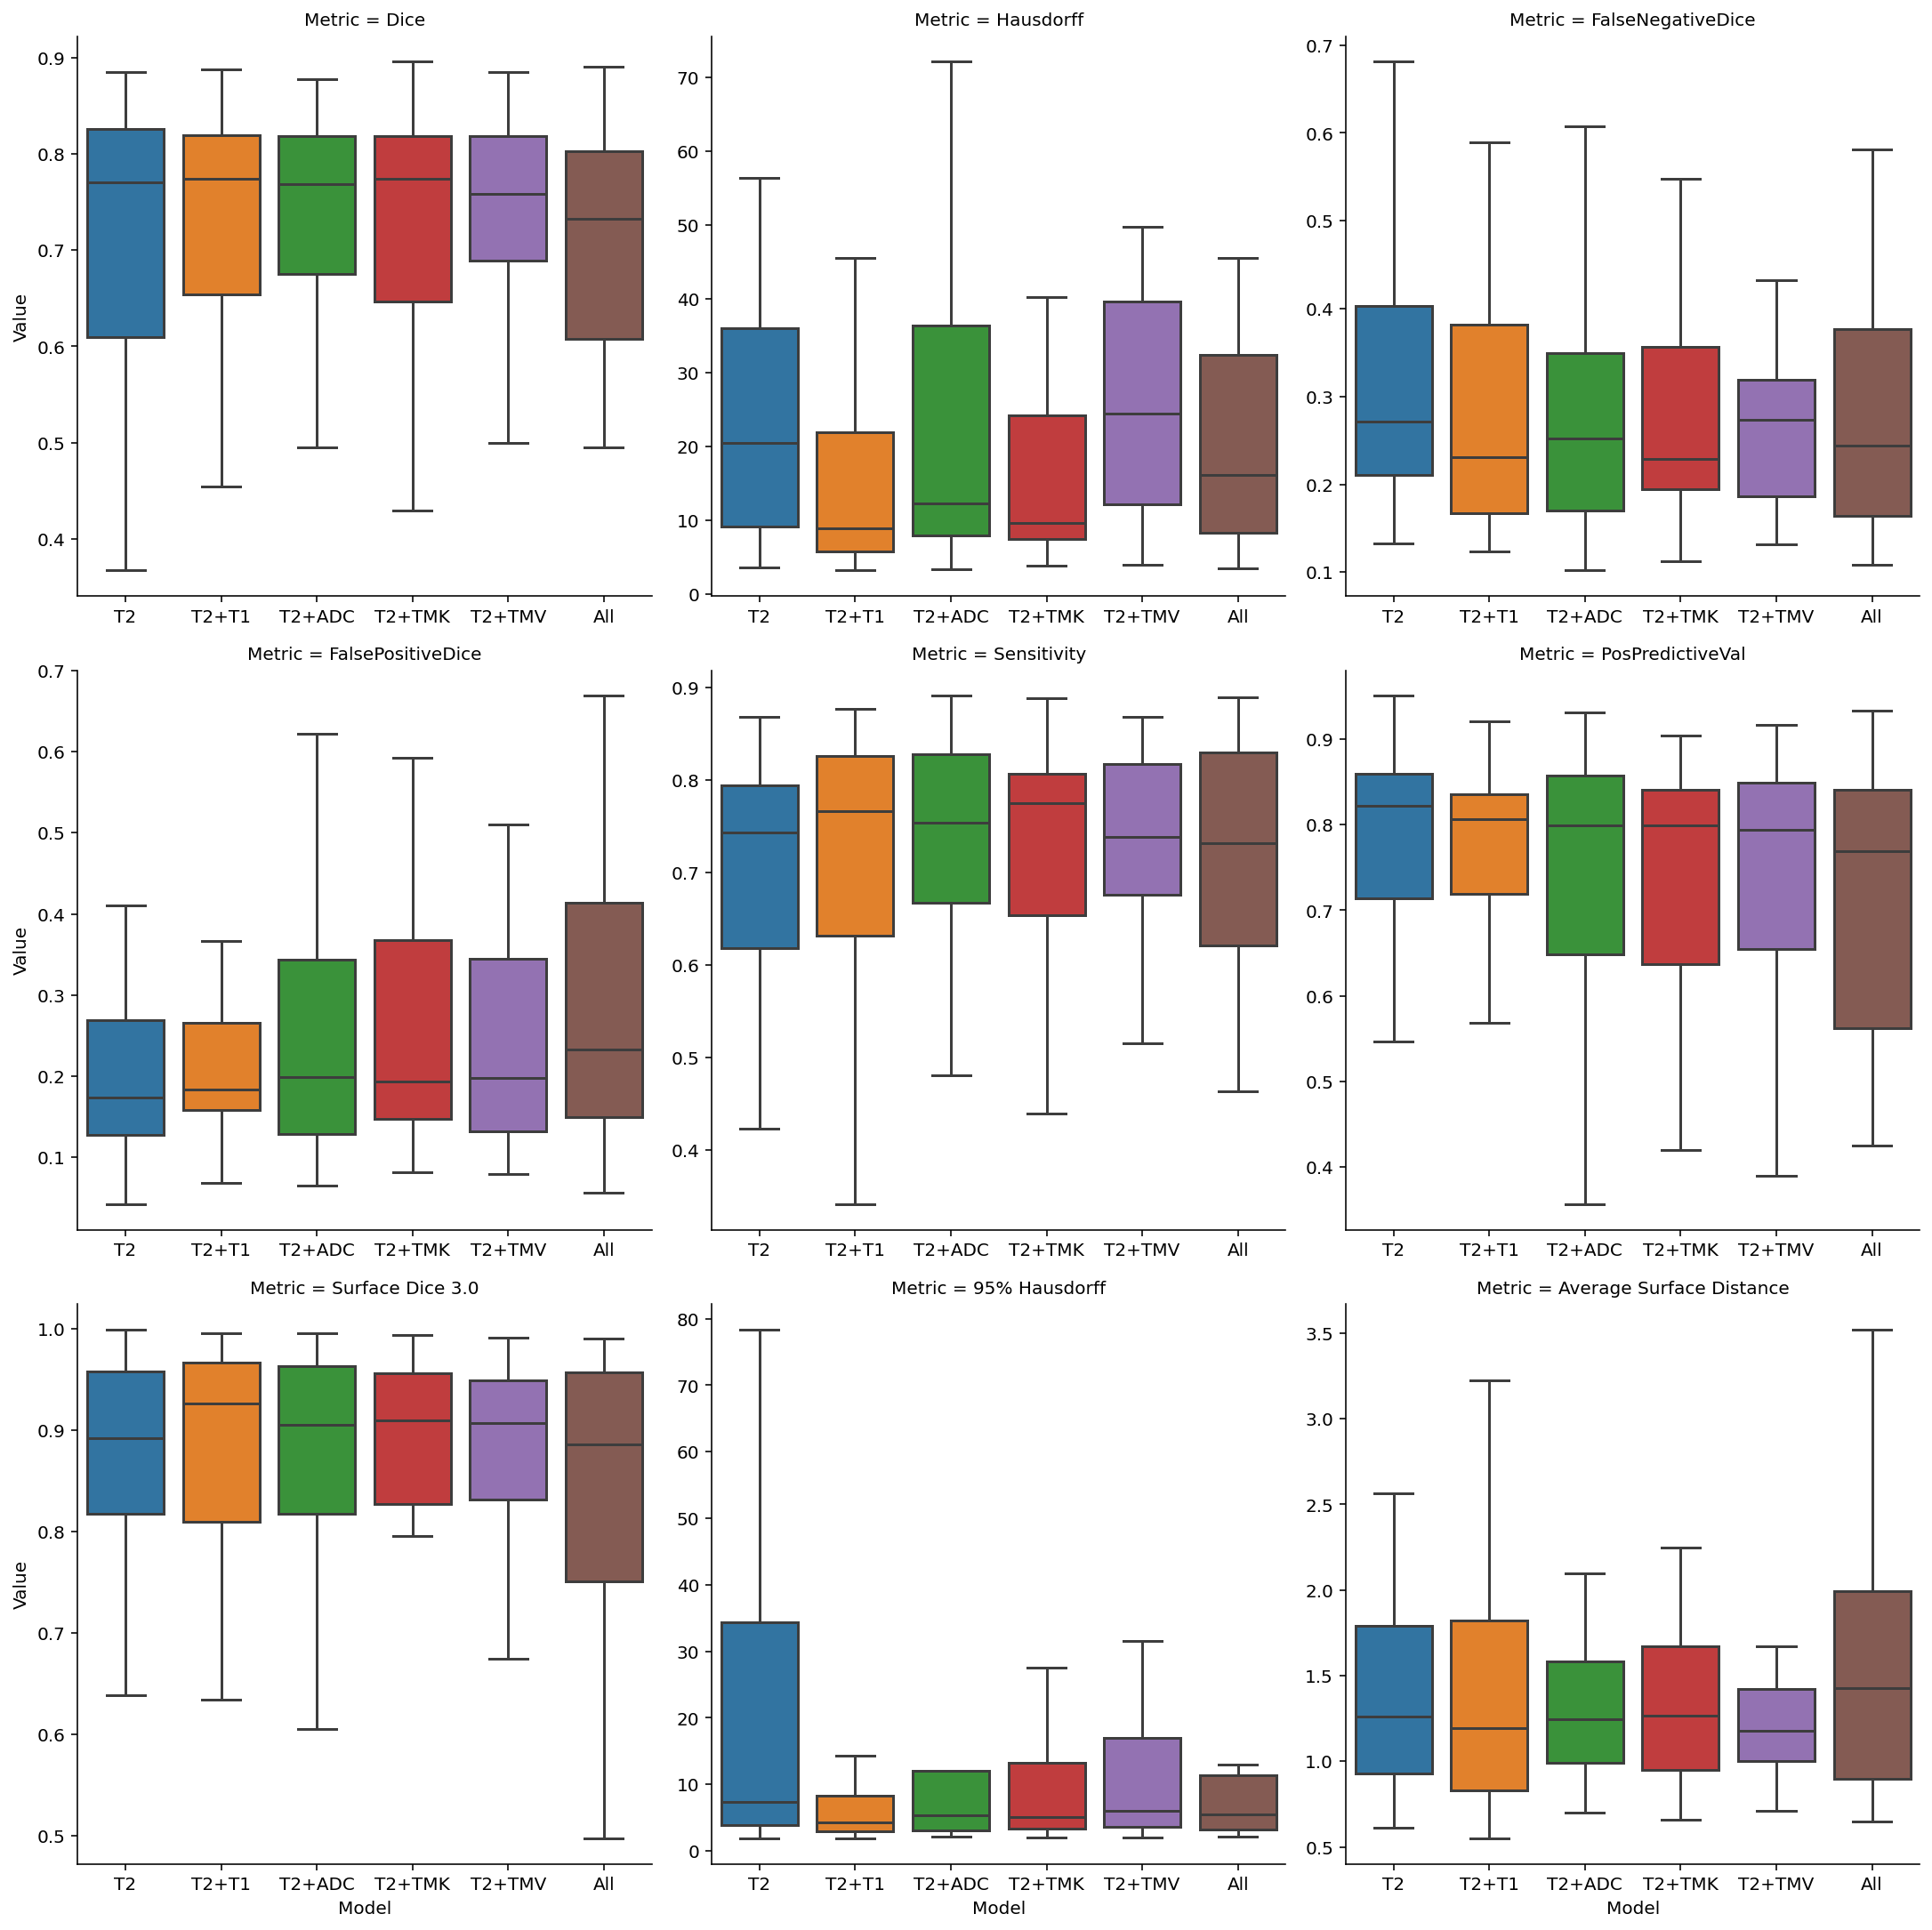

In [29]:
g = sns.catplot(x="Model", y="Value", # new
                data=master_df, kind="box",
                col = 'Metric',
                col_wrap=3,
                sharey=False,
                sharex=False,
                showfliers = False,
                height=5, aspect=1);

### Printing Mean and SD <a name="print"></a>
The following prints the mean and SD for all combinatinos so we can easily paste it in the paper results section. 

In [30]:
model_list = [
    "T2",
    "T2+T1",
    "T2+ADC",
    "T2+TMK",
    "T2+TMV",
    "All",
]

In [31]:
# print out mean and SD of the stuff above
for metric in metric_list:
    model_score_list = []
    print(metric)
    for model in model_list:
        mean = np.mean(master_df.loc[(master_df['Metric'] == metric) & (master_df['Model'] == model)]['Value'])
        std = np.std(master_df.loc[(master_df['Metric'] == metric) & (master_df['Model'] == model)]['Value'])
        string = model +" ("+ str(round(mean, 2)) + " ± " + str(round(std, 2)) + ")"
        print(string)
        model_score = [string, mean]
        model_score_list.append(model_score)
    if metric == "Dice" or metric == "Jaccard" or metric == "TotalVolumeOverlap" or metric == "CohenKappa" or metric == "Sensitivity" or metric == "PosPredictiveVal" or metric == "Surface Dice 3.0":
        model_score_list_sorted = sorted(model_score_list, key=itemgetter(1), reverse = True)
        model_score_list_sorted_final = [item[0] for item in model_score_list_sorted]
        sentance = ' > '.join(model_score_list_sorted_final)
    else:
        model_score_list_sorted = sorted(model_score_list, key=itemgetter(1), reverse = False)
        model_score_list_sorted_final = [item[0] for item in model_score_list_sorted]
        sentance = ' < '.join(model_score_list_sorted_final)
    print(sentance)

Dice
T2 (0.72 ± 0.14)
T2+T1 (0.73 ± 0.12)
T2+ADC (0.72 ± 0.15)
T2+TMK (0.72 ± 0.14)
T2+TMV (0.72 ± 0.16)
All (0.71 ± 0.12)
T2+T1 (0.73 ± 0.12) > T2+ADC (0.72 ± 0.15) > T2+TMK (0.72 ± 0.14) > T2+TMV (0.72 ± 0.16) > T2 (0.72 ± 0.14) > All (0.71 ± 0.12)
Hausdorff
T2 (26.67 ± 24.48)
T2+T1 (18.51 ± 18.65)
T2+ADC (22.17 ± 17.82)
T2+TMK (18.75 ± 18.38)
T2+TMV (31.03 ± 26.89)
All (23.23 ± 18.78)
T2+T1 (18.51 ± 18.65) < T2+TMK (18.75 ± 18.38) < T2+ADC (22.17 ± 17.82) < All (23.23 ± 18.78) < T2 (26.67 ± 24.48) < T2+TMV (31.03 ± 26.89)
FalseNegativeDice
T2 (0.34 ± 0.2)
T2+T1 (0.3 ± 0.17)
T2+ADC (0.3 ± 0.21)
T2+TMK (0.32 ± 0.24)
T2+TMV (0.27 ± 0.11)
All (0.29 ± 0.14)
T2+TMV (0.27 ± 0.11) < All (0.29 ± 0.14) < T2+T1 (0.3 ± 0.17) < T2+ADC (0.3 ± 0.21) < T2+TMK (0.32 ± 0.24) < T2 (0.34 ± 0.2)
FalsePositiveDice
T2 (0.23 ± 0.18)
T2+T1 (0.24 ± 0.14)
T2+ADC (0.25 ± 0.17)
T2+TMK (0.25 ± 0.14)
T2+TMV (0.29 ± 0.24)
All (0.3 ± 0.18)
T2 (0.23 ± 0.18) < T2+T1 (0.24 ± 0.14) < T2+TMK (0.25 ± 0.14) < T2+ADC (0.25

### Test for Normality <a name="norm"></a>
Testing to see if data are normally distributed with Shaprio wilk test. After performing a Shapiro-Wilk test for normality, we found our data was not normally distributed (p<0.05) and therefore utilized non-parametric comparison tests.

In [32]:
for model in model_list:
    print(model)
    for metric in metric_list:
        print(metric)
        samples = [master_df.loc[(master_df['Metric'] == metric) & (master_df['Model'] == model)]['Value'].tolist()]
        print(stats.shapiro(*samples)) # unpack list values 

T2
Dice
ShapiroResult(statistic=0.8763569593429565, pvalue=0.0023278100416064262)
Hausdorff
ShapiroResult(statistic=0.7985004186630249, pvalue=6.156941526569426e-05)
FalseNegativeDice
ShapiroResult(statistic=0.8122880458831787, pvalue=0.00011070975597249344)
FalsePositiveDice
ShapiroResult(statistic=0.802936315536499, pvalue=7.41905314498581e-05)
Sensitivity
ShapiroResult(statistic=0.8756505250930786, pvalue=0.0022435130085796118)
PosPredictiveVal
ShapiroResult(statistic=0.8675726056098938, pvalue=0.0014799934579059482)
Surface Dice 3.0
ShapiroResult(statistic=0.7855185270309448, pvalue=3.610385465435684e-05)
95% Hausdorff
ShapiroResult(statistic=0.7021263837814331, pvalue=1.675648945820285e-06)
Average Surface Distance
ShapiroResult(statistic=0.7174649238586426, pvalue=2.8299625682848273e-06)
T2+T1
Dice
ShapiroResult(statistic=0.8919824361801147, pvalue=0.005377110559493303)
Hausdorff
ShapiroResult(statistic=0.7622925043106079, pvalue=1.4480313438980374e-05)
FalseNegativeDice
ShapiroR

## Comparison tests <a name="compare"></a>
We used a Wilcoxon signed-rank test to evaluate differences between our baseline T2 model and models with additional channel contributions. We implemented a one-sided test with an alternative hypothesis of greater than for DSC, sensitivity, Surface DSC and PPV. We implemented a one-sided test with an alternative hypothesis of less than for HD, FND, FPD, 95% HD, and ASD. We visualized comparisons of various models against the baseline model on a heatmap of p-values. Subgroup analysis of tumor sites (base of tongue vs. tonsil) was performed using a Mann Whitney U test for each model to determine any significant differences between model performance depending on tumor subsite. 

### DataFrame Creation <a name="df3"></a>

In [33]:
# quick test to apply multiple comparisons 
from statsmodels.stats.multitest import fdrcorrection

In [34]:
# for all pairwise comparisons with T2 (control)

df2 = pd.DataFrame(columns=['Metric', 'Model', 'p_val'])
counter = -1  

model_list_copy = model_list[:]  # fastest way to copy
model_list_copy.remove('T2')
for model in model_list_copy:
    #print(model)
    for metric in metric_list:
        counter +=1
        #print(metric)
        a = master_df.loc[(master_df['Metric'] == metric) & (master_df['Model'] == model)]['Value'] 
        b = master_df.loc[(master_df['Metric'] == metric) & (master_df['Model'] == "T2")]['Value'] # T2 corresponds to what we want to compare to  
        if metric == "Dice" or metric == "Jaccard" or metric == "TotalVolumeOverlap" or metric == "CohenKappa" or metric == "Sensitivity" or metric == "PosPredictiveVal" or metric == "Surface Dice 3.0":
            p_val = stats.wilcoxon(a,b, alternative = 'greater')[1]
        else: # for metrics that go in other direction (i.e. Hausdorff)
            p_val = stats.wilcoxon(a,b, alternative = 'less')[1] 
        df2.loc[counter] = [metric, model, p_val] # add to dataframe here


In [35]:
df2 # display 

,Metric,Model,p_val
0,Dice,T2+T1,0.181837
1,Hausdorff,T2+T1,0.039323
2,FalseNegativeDice,T2+T1,0.025345
3,FalsePositiveDice,T2+T1,0.773603
4,Sensitivity,T2+T1,0.023578
5,PosPredictiveVal,T2+T1,0.738150
6,Surface Dice 3.0,T2+T1,0.023581
7,95% Hausdorff,T2+T1,0.006960
8,Average Surface Distance,T2+T1,0.245399
9,Dice,T2+ADC,0.190544


### Heatmap <a name="heat"></a>

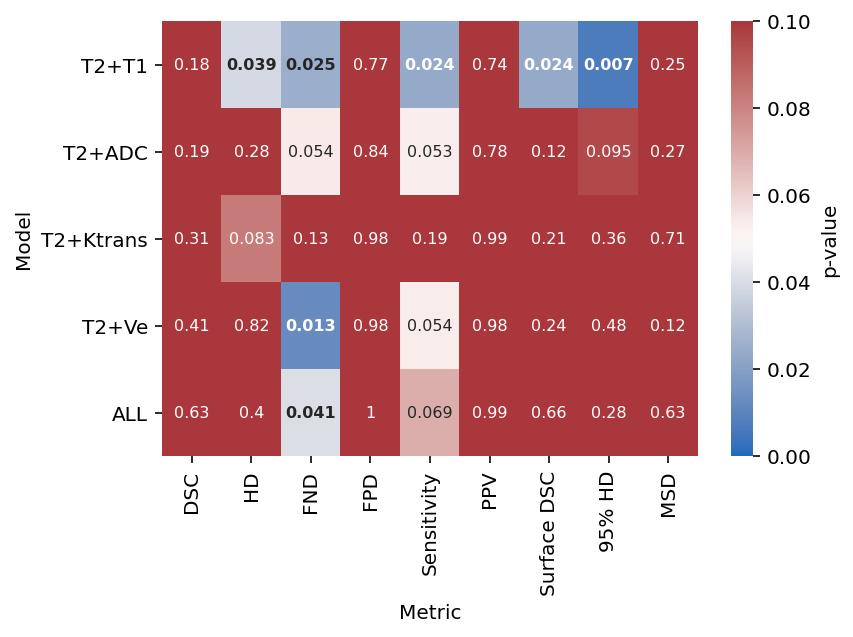

In [36]:
pivot = pd.pivot_table(df2, index='Model', columns='Metric', values='p_val') # need pivot to use heatmap
pivot = pivot.reindex(model_list_copy, axis="rows")
pivot = pivot.reindex(metric_list, axis="columns")

g = sns.heatmap(pivot, vmin=0, vmax=0.1, annot=True, cmap = "vlag", cbar_kws={'label': 'p-value'}, 
                annot_kws={"fontsize":8}, 
                xticklabels = ['DSC', 'HD', 'FND', 'FPD', 'Sensitivity', 'PPV', 'Surface DSC', '95% HD', 'MSD'],
               yticklabels = ['T2+T1', 'T2+ADC', 'T2+Ktrans', 'T2+Ve', 'ALL'])

plt.yticks(rotation=0);

for text in g.texts: # make p < 0.05 bold
    try:
        if float(text.get_text()) <= 0.05:
            text.set_weight('bold')
    except:
        continue

### Subsite Comparison <a name="subsite"></a>
The following is a subgroup analysis using Mann Whitney U tests to compare the model(s) performance based on anatomical subsite (BOT vs. tonsil).

In [37]:
# MWU just need bot vs tonsil for each metric and model 

df4 = pd.DataFrame(columns=['Metric', 'Model', 'p_val'])
counter = -1  

model_list_copy = model_list[:]  # fastest way to copy
for model in model_list_copy:
    #print(model)
    for metric in metric_list:
        counter +=1
        #print(metric)
        bot = master_df.loc[(master_df['Metric'] == metric) & (master_df['Model'] == model) & (master_df['Site'] == "base of tongue")]['Value'] 
        tonsil = master_df.loc[(master_df['Metric'] == metric) & (master_df['Model'] == model) & (master_df['Site'] == "tonsil")]['Value'] 
        p_val = stats.mannwhitneyu(bot, tonsil)[1]
        df4.loc[counter] = [metric, model, p_val] # add to dataframe here

In [38]:
df4 # display 

,Metric,Model,p_val
0,Dice,T2,0.404392
1,Hausdorff,T2,0.207854
2,FalseNegativeDice,T2,0.404392
3,FalsePositiveDice,T2,0.214185
4,Sensitivity,T2,0.456211
5,PosPredictiveVal,T2,0.261765
6,Surface Dice 3.0,T2,0.404403
7,95% Hausdorff,T2,0.346039
8,Average Surface Distance,T2,0.456211
9,Dice,T2+T1,0.491225


Subgroup analysis revealed no significant differences in model performance for any combination of models or metrics based on the site of OPC (base of tongue vs. tonsil), as all p-values were > 0.05.